In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import joblib

In [2]:
original_df = pd.read_csv('Data/diabetes_012_health_indicators_BRFSS2015.csv')
# Check missing values
print(original_df.isnull().sum())

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


Distribution for the values of for the target variable

Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64


<Axes: ylabel='count'>

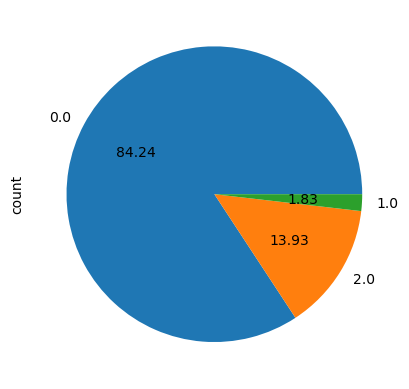

In [3]:
print('Distribution for the values of for the target variable\n')
print(original_df["Diabetes_012"].value_counts())
original_df["Diabetes_012"].value_counts().plot.pie(autopct='%.2f')

In [4]:
y = original_df.Diabetes_012
X = original_df.drop('Diabetes_012', axis=1)
X.head(1)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0


In [5]:
# Numerical Predictors
numerical_cols = ['BMI', 'MentHlth', 'PhysHlth', 'Age']
# numerical_cols = list(dict.fromkeys(numerical_cols))  # Remove duplicates just in case

# Categorical Predictors
categorical_cols = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
    'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
    'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Education', 'Income'
]

# One-hot encode categorical features and drop the first category of each
# Feature Engineering - Turns categorical data into a numerical format that a model can understand
X_cat = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Extract the numerical features
X_num = X[numerical_cols]

# Concatenate numerical and encoded categorical features
X = pd.concat([X_num, X_cat], axis=1)

# Remove any duplicated columns that may result from concat
X = X.loc[:, ~X.columns.duplicated()]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaler will only fit on training data so, calculates Mean & STD and stores this on the scaler
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols]) # Uses scaler that has only seen the traning data -> standardize 

# Combine transformed training group +  assigned clean, matching row indices
df_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

In [6]:
# Removing 'MentHlth' from being an outlier as a single unique value is being treated as an outlier but, is a valid data point
numerical_cols2 = ['BMI', 'PhysHlth', 'Age']

# Set a z-score threshold: ±1 SD → ~68.3% of data, ±2 SD → ~95.5% of data, ±3 SD → ~99.7% of data
threshold = 3    

# Calculate absolute z-scores for numerical columns
z_scores = np.abs(df_train[numerical_cols2])

# Mask: rows where any numerical feature has a z-score >= threshold of 3
outlier_mask = (z_scores >= threshold).any(axis=1)

# Get the outlier rows
outliers = df_train[outlier_mask]

# Get the cleaned training data (rows that are NOT outliers)
df_train_cleaned = df_train[~outlier_mask].reset_index(drop=True)

# Show the outliers
# print("Outlier rows removed from training data:")
# print(outliers)

# Print how many were removed
print(f"\nRemoved {len(outliers)} outliers from training data.")


Removed 12308 outliers from training data.


In [12]:
# See just the top 5 most extreme BMI cases
print(outliers[['BMI', 'MentHlth', 'PhysHlth', 'Age']].sort_values(by='BMI', ascending=False).head(5).to_dict(orient='records'))

[{'BMI': 10.529983410659645, 'MentHlth': 0.9166051825683241, 'PhysHlth': -0.4871967214577618, 'Age': -1.6484433977259525}, {'BMI': 10.529983410659645, 'MentHlth': -0.4299017021454753, 'PhysHlth': -0.4871967214577618, 'Age': 1.6269393377059982}, {'BMI': 10.529983410659645, 'MentHlth': 0.10870105174004452, 'PhysHlth': -0.4871967214577618, 'Age': 0.644324517076413}, {'BMI': 10.529983410659645, 'MentHlth': 1.589858624925224, 'PhysHlth': 0.6594755518259351, 'Age': 0.9718627906196081}, {'BMI': 10.529983410659645, 'MentHlth': -0.1606003252027154, 'PhysHlth': -0.4871967214577618, 'Age': 0.644324517076413}]


In [13]:
# Refit scaler on cleaned training data
scaler = StandardScaler()
df_train_cleaned[numerical_cols] = scaler.fit_transform(df_train_cleaned[numerical_cols])

# Apply same transformation to test data
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Summary of the original standardized training data (before outlier removal)
print("Original Standardized Training Data:")
print(df_train[numerical_cols].describe())

# Summary of the re-standardized, cleaned training data
print("\nCleaned + Re-standardized Training Data:")
print(df_train_cleaned[numerical_cols].describe())

Original Standardized Training Data:
                BMI      MentHlth      PhysHlth           Age
count  2.029440e+05  2.029440e+05  2.029440e+05  2.029440e+05
mean   2.687503e-16  4.513016e-17 -7.142400e-18 -1.776497e-16
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00
min   -2.475946e+00 -4.299017e-01 -4.871967e-01 -2.303520e+00
25%   -6.611649e-01 -4.299017e-01 -4.871967e-01 -6.658286e-01
50%   -2.074697e-01 -4.299017e-01 -4.871967e-01 -1.075203e-02
75%    3.974572e-01 -1.606003e-01 -1.431950e-01  6.443245e-01
max    1.052998e+01  3.609619e+00  2.952820e+00  1.626939e+00

Cleaned + Re-standardized Training Data:
                BMI      MentHlth      PhysHlth           Age
count  1.906360e+05  1.906360e+05  1.906360e+05  1.906360e+05
mean   6.336278e-18 -5.529334e-17  4.804389e-17 -2.767463e-17
std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00
min   -2.876142e+00 -4.142922e-01 -4.554221e-01 -2.304848e+00
25%   -7.114224e-01 -4.142922e-01 -4.554221e-01 -6.74

#### Understanding the outliers
- Both have a mean ~0 and a std ~1 as expected
- max BPI has decreased from 10.5 std to 3.6 std
- mental health has increased from 3.6 max std to 5.47 std

In [20]:
# Columns you're checking for outliers
cols = ['BMI', 'MentHlth', 'PhysHlth', 'Age']

# For each row, find which column has the max value over the threshold
threshold = 3
outlier_only = outliers[cols].copy()

# Mask values <= threshold
outlier_only = outlier_only.where(outlier_only > threshold)

# Find the column with the maximum value per row (ignoring NaNs)
primary_outlier_column = outlier_only.idxmax(axis=1)

# Drop rows where all values were below threshold (i.e., no max column)
primary_outlier_column = primary_outlier_column.dropna()

# Count how often each column was the primary outlier
outlier_counts = primary_outlier_column.value_counts()

print("Outlier counts by column (only one column per row):")
print(outlier_counts)


Outlier counts by column (only one column per row):
MentHlth    10057
BMI          2251
Name: count, dtype: int64


In [21]:
outliers[numerical_cols].describe()

,BMI,MentHlth,PhysHlth,Age
count,12308.000000,12308.000000,12308.000000,12308.000000
mean,1.002863,2.991471,1.101198,-0.175559
std,2.128997,1.379720,1.506134,0.912400
min,-2.475946,-0.429902,-0.487197,-2.303520
25%,-0.358701,3.609619,-0.487197,-0.665829
50%,0.321841,3.609619,0.659476,-0.010752
75%,1.758543,3.609619,2.952820,0.316786
max,10.529983,3.609619,2.952820,1.626939


#### BMI
- BMI std of 1 means The average outlier BMI z-score is already 1 std dev above the (overall) mean
- max = 10.53, is way beyond 3 stds from the mean (even though the outier data is not normally distributed)
- Extreme high-end outliers driving up the max.
#### MentHlth
- For MentHlth 75% of the values are all the same number 3.609 which suggests that a single uniquely high value is being captured
- Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many
days during the past 30 days was your mental health not good?
- 1 - 30 Number of days.
- Currently we are excluding this as an outlier, we should keep this in 